# Análisis de datos R&D - LHCO 2020

En este notebook intentaremos entender la distribución y relaciones de los datos R&D del LHC Olympics 2020. Los datos se pueden descargar de [este link](https://zenodo.org/record/4536377).
El código está basado en [este notebook](https://github.com/lhcolympics2020/parsingscripts/blob/master/LHCOlympics2020_pyjetexample.ipynb).

In [1]:
# Importamos las librerías a utilizar
import h5py                             # Para manejar los archivos .h5
import numpy as np                      # Manejo de matrices
import matplotlib.pyplot as plt         # Plots
from pyjet import cluster,DTYPE_PTEPM   # Clustering de los jets
import pandas as pd                     # Manejo de tablas
import os.path                          # Manejo de directorios
from os import path

## Lectura de datos

In [2]:
# leemos el archivo como un DataFrame de pandas
df = pd.read_hdf("../events_anomalydetection.h5")

In [3]:
# Vemos que sea del tipo esperado
type(df)

pandas.core.frame.DataFrame

In [4]:
# Vemos como luce el DataFrame
df.head()

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


El archivo tiene un evento por fila. Cada fila está compuesta por:
- al menos un jet anti-kT R = 1.0 
- con pseudorapidez $|\eta|<2,5$ 
- y momento transversal $pT> 1,2$ TeV. 

Para cada evento, hay una lista de todos los hadrones:

|Evento|$pT$ | $\eta$ | $\phi$ | $pT$ | $\eta$ | $\phi$ | $\cdots$ | Señal? |
|------|-----|--------|--------|------|--------|--------|--------|--------|
| 1    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 1.0|
| 2    | $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|
| $\vdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| $\cdots$| 0.0|


con relleno de ceros hasta 700 hadrones.


In [5]:
# Sin embargo, tenemos muchos eventos
df.shape

(1100000, 2101)

Haremos la exploración de los datos en un conjunto más pequeño de eventos:

In [6]:
# Para el análisis, escogemos 1000 eventos de la muestra
n_eventos = 10000

In [7]:
dfsample = df.sample(n=n_eventos)

In [8]:
# Los guardamos en un archivo .h5 para tener la muestra en la que se haga el análisis
if path.exists("events_anomalydetection_tiny_{}.h5".format(n_eventos))!= True: 
    dfsample.to_hdf("events_anomalydetection_tiny_{}.h5".format(n_eventos), key='df', mode='w',complevel=5,complib='blosc')

In [9]:
# Utilizamos estos datos para el análisis
eventos_tiny = pd.read_hdf("events_anomalydetection_tiny_{}.h5".format(n_eventos))

In [10]:
# Tenemos un dataframe de 
# 1000 eventos x 700 hadrones * 3 características ( pT, eta, phi) + 1 columna (si es señal o fondo)
# El dataframe debe ser 1000x2101

np.shape(eventos_tiny)

(10000, 2101)

La última columna tiene la información sobre si el evento es señal(1) o fondo(0)

In [11]:
eventos_tiny.iloc[:,-1].head()

76965     0.0
663565    0.0
764927    1.0
172549    0.0
155989    0.0
Name: 2100, dtype: float64

Podemos saber el porcentaje de señal y de fondo en la muestra:

In [19]:
senal = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 1.0]
fondo = eventos_tiny.loc[eventos_tiny.iloc[:,-1] == 0.0]

n_senal = senal.shape[0]
n_fondo = fondo.shape[0]
n_eventos = eventos_tiny.shape[0]

columna_senal = df.iloc[:,-1]
senaldf = columna_senal.loc[df.iloc[:,-1] == 1.0]
fondodf = columna_senal.loc[df.iloc[:,-1] == 0.0]

ndf_senal = senaldf.shape[0]
ndf_fondo = fondodf.shape[0]
n_eventosdf = df.shape[0]

print('El {}% de los datos en la muestra de {} eventos es señal y el {}% es fondo'.format(n_senal/n_eventos*100,n_eventos,n_fondo/n_eventos*100 ))
print('El {}% de los datos R&D es señal y el {}% es fondo'.format(ndf_senal/n_eventosdf*100,ndf_fondo/n_eventosdf*100 ))

El 9.27% de los datos en la muestra de 10000 eventos es señal y el 90.73% es fondo
El 9.090909090909092% de los datos R&D es señal y el 90.9090909090909% es fondo


La ventaja de tener los datos en un dataframe es que podemos **utilizar la información fácilmente**.

Por ejemplo, para el clustering vamos a utilizar una lista que contenga los pT de cada jet si estos son mayores que 0.

In [20]:
# Por ejemplo, para el primer evento
lista= [data for data in eventos_tiny.iloc[0,::3] if data > 0] # pT, eta, phi, pT... Los pT están cada 3

# Vemos los primeros elementos
lista[0:5]

[0.3059094250202179,
 0.528335690498352,
 0.6266452670097351,
 0.40856659412384033,
 0.8071150183677673]

In [21]:
# el largo de cada lista varía según el evento. Esto representa la cantidad de hadrones por evento.
for evento in range(5):
    # Quitamos la fila de señal para no contarla como parte de los datos
    eventos_ss = eventos_tiny.iloc[:,:-1]  
    
    lista = [data for data in eventos_ss.iloc[evento,::3] if data > 0]
    print("Cantidad de hadrones en evento {}: {}".format(evento, len(lista)))

Cantidad de hadrones en evento 0: 145
Cantidad de hadrones en evento 1: 127
Cantidad de hadrones en evento 2: 80
Cantidad de hadrones en evento 3: 319
Cantidad de hadrones en evento 4: 144


Calculamos el **número promedio de hadrones** para los eventos de señal y de fondo:

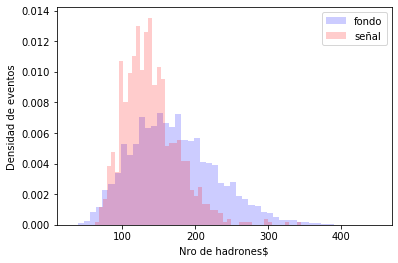

El número promedio de hadrones en los eventos de señal: 139 y en los eventos de fondo: 170


In [22]:
contar_h = eventos_tiny.copy()

# Quitamos la fila de señal para no contarla como parte de los datos
contar_h_ss = contar_h.iloc[:,:-1]
contar_h['Nro_hadrones'] = contar_h_ss.astype(bool).sum(axis=1)/3

h_senal = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 1.0]        # -2 porque al crear la columna Nro_hadrones,
h_fondo = contar_h['Nro_hadrones'].loc[contar_h.iloc[:,-2] == 0.0]        # la de señal ya no es la última

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

# Hacemos los histogramas
h_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True)
h_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)

# Agregamos información al gráfico
plt.xlabel(r'Nro de hadrones$')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()

print('El número promedio de hadrones en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(h_senal.mean()), int(h_fondo.mean())))

Podemos hacer dataframes de solamente pT, eta o phi

In [23]:
# pT está cada 3, partiendo de 0.
pt_df = eventos_tiny.iloc[:,::3]

pt_df.head()

,0,3,6,9,12,15,18,21,24,27,...,2073,2076,2079,2082,2085,2088,2091,2094,2097,2100
76965,0.305909,0.528336,0.626645,0.408567,0.807115,1.751847,5.753023,5.026085,2.599985,1.691981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
663565,0.346507,2.144240,3.382292,7.478111,3.700897,1.723265,1.035048,2.286025,0.902282,1.148937,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
764927,0.294778,0.252465,0.468315,0.873560,2.932212,3.113694,2.920786,23.101059,25.980949,174.390106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
172549,0.427332,4.181561,4.167324,14.642617,2.055962,2.496214,3.772997,2.432942,1.444579,3.499435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
155989,0.185630,0.456190,0.654748,1.376008,5.394917,1.839111,2.167102,3.372581,2.161964,1.225603,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Hacemos lo mismo con eta y phi

# Definimos la columna con la información de señal o fondo
senal_column = eventos_tiny[2100]

# Concatenamos esta a los slicing de los dataframe
eta_df = pd.concat([eventos_tiny.iloc[:,1::3],senal_column], axis = 1)
phi_df = pd.concat([eventos_tiny.iloc[:,2::3],senal_column], axis = 1)

### Gráficas de la media

Antes del clustering, podemos graficar la distribución de los datos para cada evento.

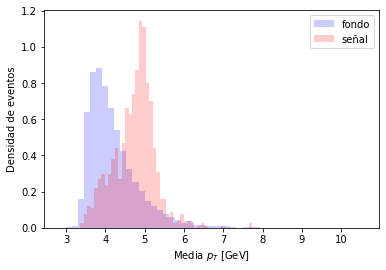

In [25]:
# Distribución de la media de pT para cada evento

# Filtramos que elementos son señal o fondo
pt_senal = pt_df.loc[pt_df.iloc[:,-1] == 1.0]
pt_fondo = pt_df.loc[pt_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
pt_senal = pt_senal.iloc[:,:-1]
pt_fondo = pt_fondo.iloc[:,:-1]

# Calculamos la media de las filas y hacemos un histograma
meanpt_fondo = pt_fondo.mean(axis=1)
meanpt_senal = pt_senal.mean(axis=1)

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

meanpt_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True) # density = True normaliza
meanpt_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'Media $p_{T}$ [GeV]')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

Podemos hacer lo mismo para $\eta$ y $\phi$:

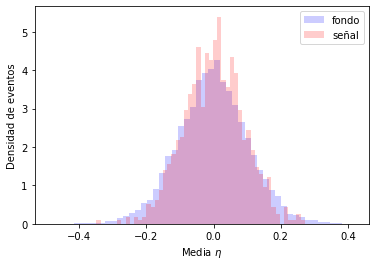

In [26]:
# Distribución de la media de eta para cada evento

# Filtramos que elementos son señal o fondo
eta_senal = eta_df.loc[eta_df.iloc[:,-1] == 1.0]
eta_fondo = eta_df.loc[eta_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
eta_senal = eta_senal.iloc[:,:-1]
eta_fondo = eta_fondo.iloc[:,:-1]

# Calculamos la media de las filas y hacemos un histograma
meaneta_fondo = eta_fondo.mean(axis=1)
meaneta_senal = eta_senal.mean(axis=1)

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

meaneta_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True)
meaneta_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'Media $\eta$')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

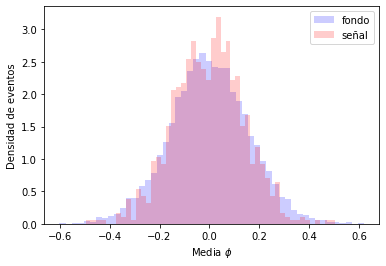

In [27]:
# Distribución de la media de phi para cada evento

# Filtramos que elementos son señal o fondo
phi_senal = phi_df.loc[phi_df.iloc[:,-1] == 1.0]
phi_fondo = phi_df.loc[phi_df.iloc[:,-1] == 0.0]

# Eliminamos la ultima columna de ambos
phi_senal = phi_senal.iloc[:,:-1]
phi_fondo = phi_fondo.iloc[:,:-1]


# Calculamos la media de las filas y hacemos un histograma
meanphi_fondo = phi_fondo.mean(axis=1)
meanphi_senal = phi_senal.mean(axis=1)

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

meanphi_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True)
meanphi_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'Media $\phi$')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()
#plt.savefig("leadjetpt.pdf")

### Gráficas del hadrón más energético

Analizamos el hadron más energético. Para esto hallaremos el mayor pT en cada evento

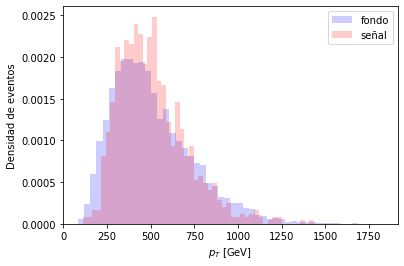

In [28]:
# Distribución de la pT para hadron mas energetico en cada evento

# Hallamos el maximo en cada fila para señal y fondo
ptmax_senal = pt_senal.max(axis=1)
ptmax_fondo = pt_fondo.max(axis=1)

# Hallamos los nombres de las columnas. Lo usaremos para obtener eta y phi de este hadron
col_ptmax_s = pt_senal.idxmax(axis=1)
col_ptmax_f = pt_fondo.idxmax(axis=1)

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

ptmax_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True) # density = True normaliza
ptmax_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()

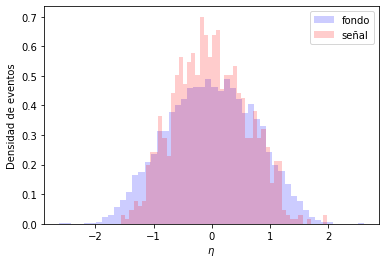

In [29]:
# Hallamos la columna con eta del hadron mas energetico. Es la siguiente a la de pT mas energetico.
col_etamax_s = col_ptmax_s + 1 
col_etamax_f = col_ptmax_f + 1

# Hacemos el mapeo de las columnas para extraerlas del dataframe
# https://stackoverflow.com/questions/50341927/select-pandas-column-for-each-row-by-index-list

etamax_senal = pd.Series(eta_senal.lookup(col_etamax_s.index, col_etamax_s.values))
etamax_fondo = pd.Series(eta_fondo.lookup(col_etamax_f.index, col_etamax_f.values))

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

# Graficamos los histogramas normalizados
etamax_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True) # density = True normaliza
etamax_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'$\eta$')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()

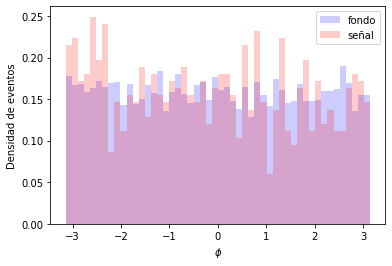

In [30]:
# Hallamos la columna con eta del hadron mas energetico. Es la segunda siguiente a la de pT mas energetico.
col_phimax_s = col_ptmax_s + 2 
col_phimax_f = col_ptmax_f + 2

# Hacemos el mapeo de las columnas para extraerlas del dataframe
phimax_senal = pd.Series(phi_senal.lookup(col_phimax_s.index, col_phimax_s.values))
phimax_fondo = pd.Series(phi_fondo.lookup(col_phimax_f.index, col_phimax_f.values))

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

phimax_fondo.plot.hist(bins=50, facecolor='b', alpha=0.2, label='fondo', density=True) # density = True normaliza
phimax_senal.plot.hist(bins=50, facecolor='r', alpha=0.2, label='señal', density=True)
plt.xlabel(r'$\phi$')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()

## Clustering

Para el clustering vamos a usar la librería <code>pyjet</code>. Esta librería permite hacer el clustering de los jets mediante FastJet y arreglos de NumPy. 

**FastJet** posee 3 clases principales que formarán parte del clustering:
- *PseudoJets*: provee un jet con cuadri-momento y algunos indices internos para situarlo en el contexto de una secuencia de clustering de jets.
- *JetDefinition*: contiene especificaciones sobre cómo se hará el clustering
- *ClusterSequence*: la clase que lleva a cabo el clustering y provee acceso a los jets finales.

Como input tenemos los 1000 eventos con hasta 700 hadrones y como output tendremos:
- Un diccionario con los jets de fondo y de señal en objetos PseudoJets
- Tres diccionario separado en señal y fondo con:
   - $pT$ del jet principal de cada evento
   - $\eta$ del jet principal de cada evento
   - $\phi$ del jet principal de cada evento


El código para el clustering es el siguiente:

In [31]:
# Creamos las variables a utilizar
alljets={}                                     # diccionario con los jets de cada evento y su información
leadpT={}                                      # diccionario de pT del jet principal de cada evento
leadeta={}                                     # diccionario de eta del jet principal de cada evento
leadphi={}                                     # diccionario de phi del jet principal de cada evento
n_eventos = eventos_tiny.shape[0]              # número de eventos (1000)
n_hadrones = int((eventos_tiny.shape[1]-1)/3)  # número de hadrones (700) 
                                               # [-1 para eliminar la columna señal, /3 por las 3 caracteristicas de cada hadron]

print('CLUSTERING DE JETS')
print("En estos datos hay {} eventos y {} hadrones p/evento".format(n_eventos, n_hadrones))

for mitipo in ['fondo','senal']:
    # Creamos el key para cada diccionario 
    alljets[mitipo]=[] 
    leadpT[mitipo]=[]
    leadeta[mitipo]=[]  
    leadphi[mitipo]=[]
    
    for evento in range(n_eventos):
        # Indicamos que el código está corriendo
        if (evento%1000==0):
            print(mitipo,evento)
            pass
        
        # La última columna tiene la información sobre si el evento es señal(1) o fondo(0)
        essenal = eventos_tiny.iloc[evento,-1]
        
        # Si estamos en fondo solo analizamos los eventos que son fondo y viceversa.
        if (mitipo=='fondo' and essenal):
            continue
        elif (mitipo=='senal' and essenal==0):
             continue            
        
        # Eliminamos la columna de señal para evitar problemas al obtener el pT (porque cuando es señal es >0)
        eventos_tiny_ss = eventos_tiny.iloc[:,:-1]
        
        # Creamos un numpy array de ceros del tamaño de la cantidad de datos distintos de cero que hay en el evento
        # ** Buscar que es  pyjet DTYPE_PTEPM **
        pseudojets_input = np.zeros(len([data for data in eventos_tiny_ss.iloc[evento,::3] if data > 0]), dtype=DTYPE_PTEPM) 
        
        for hadron in range(n_hadrones):
            if (eventos_tiny.iloc[evento,hadron*3]>0): ## si pT > 0 
                
                ## Llenamos el arreglo con pT, eta y phi de cada "partícula"
                pseudojets_input[hadron]['pT'] = eventos_tiny.iloc[evento,hadron*3] 
                pseudojets_input[hadron]['eta'] = eventos_tiny.iloc[evento,hadron*3+1]
                pseudojets_input[hadron]['phi'] = eventos_tiny.iloc[evento,hadron*3+2]
                
                pass
            pass
        
        ## Devuelve una "ClusterSequence" (un tipo de lista de pyjet)
        ## ** No sé en verdad que está haciendo la función. clustering con anti-kt? o con que? que es p? ## 
        secuencia = cluster(pseudojets_input, R=1.0, p=-1) 
        
        ## Con inclusive_jets accedemos a todos los jets que fueron clusterizados
        ## y filtramos los que tienen pT mayor que 20
        ## Hacemos una lista con objetos PseudoJet
        jets = secuencia.inclusive_jets(ptmin=20) 
        
        # Agrega el pT, eta y phi del jet principal
        # ** No sé cómo están en orden **
        leadpT[mitipo] += [jets[0].pt] 
        leadeta[mitipo] += [jets[0].eta] 
        leadphi[mitipo] += [jets[0].phi] 
        
        # agregamos todos los jets a alljets
        alljets[mitipo] += [jets] 
        
        ###################################CHEQUEANDO LOS TIPOS DE VARIABLES#############################################
        if evento==0 or evento==2000: 
            print('BREVE ANALISIS DE LAS VARIABLES')
            print('**pseudojets_input**: tipo {}, largo {}'.format(type(pseudojets_input), len(pseudojets_input)))
            print('**secuencia**: tipo {}'.format(type(secuencia)))
            print('**jets**: tipo {}, largo {}, tipo de objetos que contiene {}'.format(type(jets), len(jets), type(jets[0])))
            print('**leadpT**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(leadpT), len(leadpT), type(leadpT[mitipo][0])))
            print('**alljets**: tipo {}, largo {}, tipo de objeto que contiene {}'.format(type(alljets), len(alljets), type(alljets[mitipo][0])))
            
        pass        

CLUSTERING DE JETS
En estos datos hay 10000 eventos y 700 hadrones p/evento
fondo 0
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 145
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 2, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'list'>
fondo 1000
fondo 2000
BREVE ANALISIS DE LAS VARIABLES
**pseudojets_input**: tipo <class 'numpy.ndarray'>, largo 191
**secuencia**: tipo <class 'pyjet._libpyjet.ClusterSequence'>
**jets**: tipo <class 'list'>, largo 4, tipo de objetos que contiene <class 'pyjet._libpyjet.PseudoJet'>
**leadpT**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'float'>
**alljets**: tipo <class 'dict'>, largo 1, tipo de objeto que contiene <class 'list'>
fondo 3000
fondo 4000
fondo 

Analicemos los datos para los jets reconstruidos. Veamos la distribución de jets reconstruidos para señal y fondo:

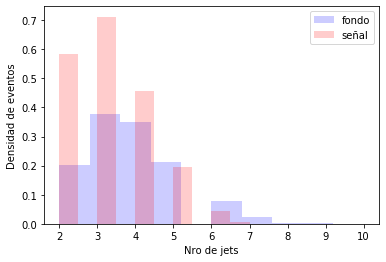

El número promedio de jets en los eventos de señal: 3 y en los eventos de fondo: 3


In [32]:
# Creamos un diccionario con la cantidad de jets reconstruidos por evento para señal y fondo
nro_jets = {}
for mitipo in alljets.keys():
    nro_jets[mitipo] = []
    nro_jets[mitipo] += [len(lista) for lista in alljets[mitipo]]

# Creamos series de los datos, para poder graficar fácilmente
nro_jets_fondo = pd.Series( (v for v in nro_jets['fondo']) )
nro_jets_senal = pd.Series( (v for v in nro_jets['senal']) )

# Graficamos
fig = plt.figure()

# Definimos los ejes
ax = fig.add_subplot(1, 1, 1)

# Hacemos los histogramas normalizados
nro_jets_fondo.plot.hist(bins=10, facecolor='b', alpha=0.2, label='fondo', density=True)
nro_jets_senal.hist(bins=10, facecolor='r', alpha=0.2, label='señal', density=True)

# Agregamos información al gráfico
plt.grid(b=None)
plt.xlabel(r'Nro de jets')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.show()

print('El número promedio de jets en los eventos de señal: {} y en los eventos de fondo: {}'.format(int(nro_jets_senal.mean()), int(nro_jets_fondo.mean())))


### Gráficas

**Graficamos** la distribución de los valores de los jets principales:

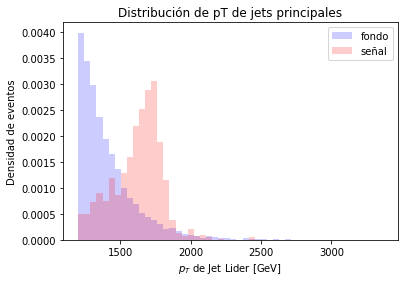

<Figure size 432x288 with 0 Axes>

In [34]:
# Distribución de pT

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadpT['fondo'], bins=50, facecolor='b', alpha=0.2, label='fondo', density=True)
plt.hist(leadpT['senal'], bins=b, facecolor='r', alpha=0.2,label='señal', density=True)
plt.xlabel(r'$p_{T}$ de Jet Lider [GeV]')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de pT de jets principales')
plt.show()
plt.savefig("leadjetpt.pdf")

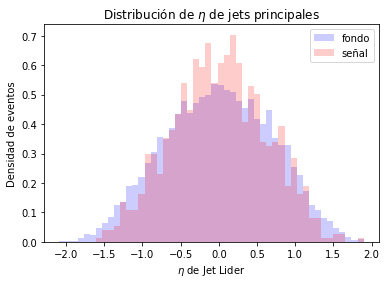

<Figure size 432x288 with 0 Axes>

In [35]:
# Distribución de eta

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadeta['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo', density=True)
plt.hist(leadeta['senal'], bins=b, facecolor='r', alpha=0.2,label='señal', density=True)
plt.xlabel(r'$\eta$ de Jet Lider')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de $\eta$ de jets principales')
plt.show()
plt.savefig("leadjeteta.pdf")

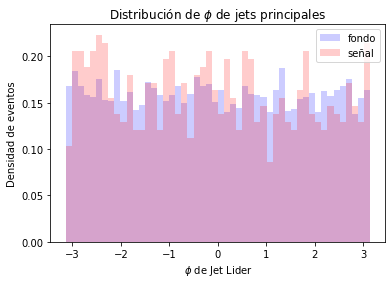

<Figure size 432x288 with 0 Axes>

In [36]:
# Distribución de phi

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(leadphi['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo', density=True)
plt.hist(leadphi['senal'], bins=b, facecolor='r', alpha=0.2,label='señal', density=True)
plt.xlabel(r'$\phi$ de Jet Lider')
plt.ylabel('Densidad de eventos')
plt.legend(loc='upper right')
plt.title('Distribución de $\phi$ de jets principales')
plt.show()
plt.savefig("leadjetphi.pdf")

Utilizando funciones de FastJet sobre los objetos PseudoJets podemos calcular la masa invariante facilmente:

In [37]:
# MASA INVARIANTE
mjj={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    mjj[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        # De cada evento sumamos la energía de los dos jets más energéticos
        E = jet[0].e + jet[1].e
        
        # Igual aqui pero con las componentes del momento
        px = jet[0].px + jet[1].px 
        py = jet[0].py + jet[1].py
        pz = jet[0].pz + jet[1].pz
        
        ## Calculamos la masa invariante
        mjj[mitipo]+=[(E**2-px**2-py**2-pz**2)**0.5] 
        pass
    pass

Y graficamos la distribución

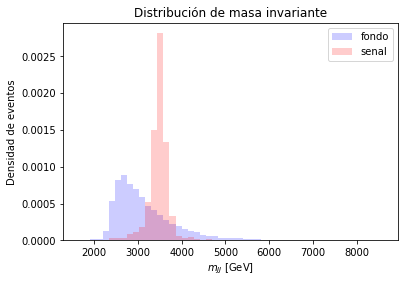

<Figure size 432x288 with 0 Axes>

In [38]:
# Distribución de masa invariante

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
n,b,p = plt.hist(mjj['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo', density=True)
plt.hist(mjj['senal'], bins=b, facecolor='r', alpha=0.2,label='senal', density=True)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Densidad de eventos')
plt.title('Distribución de masa invariante')
plt.legend(loc='upper right')
plt.show()
plt.savefig("mjj.pdf")

In [39]:
# DISTANCIA ENTRE JETS 
distancia={}

for mitipo in ['fondo','senal']:
    n_eventos = len(alljets[mitipo])
    distancia[mitipo]=[]
    
    for evento in range(n_eventos): 
        
        jet = alljets[mitipo][evento]
        
        ## Calculamos la distancia
        distancia[mitipo]+=[( (jet[0].phi-jet[1].phi)**2+(jet[0].eta-jet[1].eta)**2 )**0.5] 
        pass
    pass

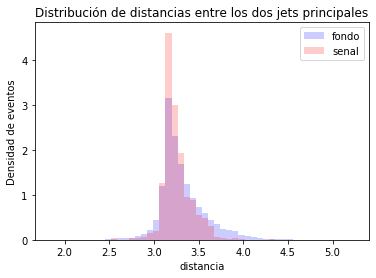

<Figure size 432x288 with 0 Axes>

In [40]:
# Distribución de distancias
fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

n,b,p = plt.hist(distancia['fondo'], bins=50, facecolor='b', alpha=0.2,label='fondo', density=True)
plt.hist(distancia['senal'], bins=b, facecolor='r', alpha=0.2,label='senal', density=True)
plt.xlabel(r'distancia')
plt.ylabel('Densidad de eventos')
plt.title('Distribución de distancias entre los dos jets principales')
plt.legend(loc='upper right')
plt.show()
plt.savefig("mjj.pdf")

También podemos ver si hay alguna **relación entre las variables**

### Relación de la masa invariante con las demás variables

Text(0, 0.5, '$m_{jj}$ [GeV]')

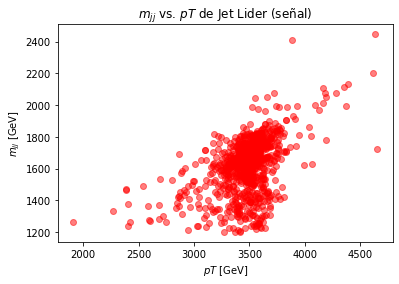

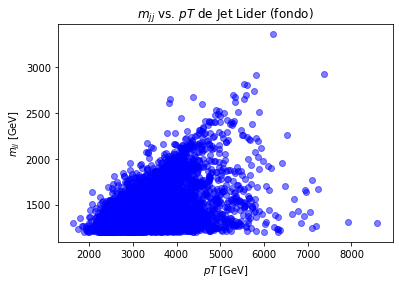

In [41]:
# Relación entre mjj y pT

# señal
fig = plt.figure()
plt.scatter(mjj['senal'], leadpT['senal'], c='r', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $pT$ de Jet Lider (señal)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$m_{jj}$ [GeV]')

# fondo
fig = plt.figure()
plt.scatter(mjj['fondo'], leadpT['fondo'], c='b', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $pT$ de Jet Lider (fondo)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$m_{jj}$ [GeV]')

Text(0, 0.5, '$m_{jj}$ [GeV]')

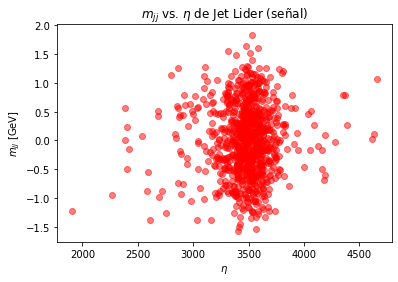

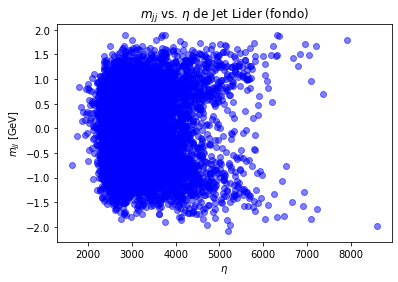

In [42]:
# Relación entre mjj y eta

# señal
fig = plt.figure()
plt.scatter(mjj['senal'], leadeta['senal'], c='r', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $\eta$ de Jet Lider (señal)')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m_{jj}$ [GeV]')

# fondo
fig = plt.figure()
plt.scatter(mjj['fondo'], leadeta['fondo'], c='b', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $\eta$ de Jet Lider (fondo)')
plt.xlabel(r'$\eta$')
plt.ylabel(r'$m_{jj}$ [GeV]')

Text(0, 0.5, '$m_{jj}$ [GeV]')

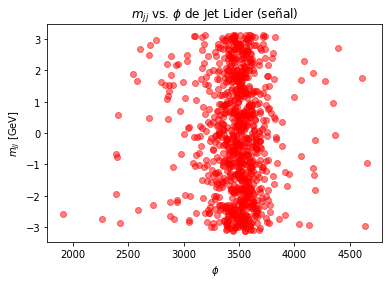

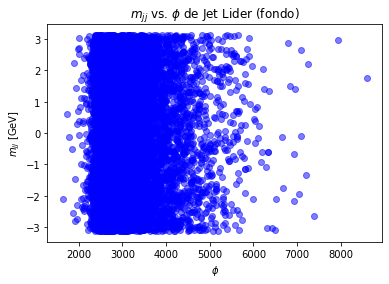

In [43]:
# Relación entre mjj y phi

# señal
fig = plt.figure()
plt.scatter(mjj['senal'], leadphi['senal'], c='r', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $\phi$ de Jet Lider (señal)')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m_{jj}$ [GeV]')

# fondo
fig = plt.figure()
plt.scatter(mjj['fondo'], leadphi['fondo'], c='b', alpha=0.5)
plt.title(r'$m_{jj}$ vs. $\phi$ de Jet Lider (fondo)')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$m_{jj}$ [GeV]')

### Relación de pT con las demás variables 

Text(0, 0.5, '$\\eta$r')

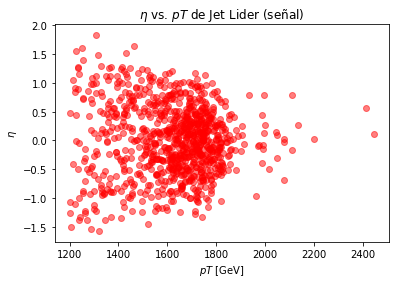

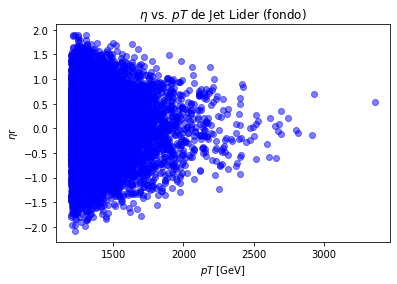

In [44]:
# Relación entre eta y pT

# señal
fig = plt.figure()
plt.scatter(leadpT['senal'], leadeta['senal'], c='r', alpha=0.5)
plt.title(r'$\eta$ vs. $pT$ de Jet Lider (señal)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\eta$')

# fondo
fig = plt.figure()
plt.scatter(leadpT['fondo'], leadeta['fondo'], c='b', alpha=0.5)
plt.title(r'$\eta$ vs. $pT$ de Jet Lider (fondo)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\eta$r')

Text(0, 0.5, '$\\phi$')

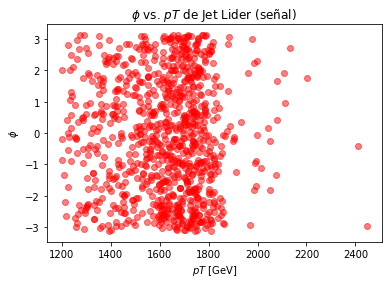

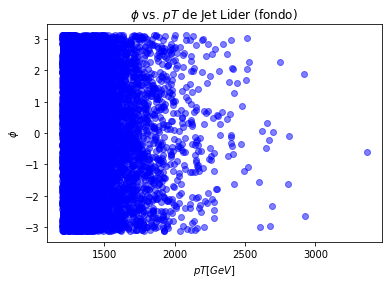

In [45]:
# Relación entre phi y pT

# señal
fig = plt.figure()
plt.scatter(leadpT['senal'], leadphi['senal'], c='r', alpha=0.5)
plt.title(r'$\phi$ vs. $pT$ de Jet Lider (señal)')
plt.xlabel(r'$pT$ [GeV]')
plt.ylabel(r'$\phi$')

# fondo
fig = plt.figure()
plt.scatter(leadpT['fondo'], leadphi['fondo'], c='b', alpha=0.5)
plt.title(r'$\phi$ vs. $pT$ de Jet Lider (fondo)')
plt.xlabel(r'$pT [GeV]$ ')
plt.ylabel(r'$\phi$')

### Relación de $\phi$ con las demás variables

Text(0, 0.5, '$\\eta$')

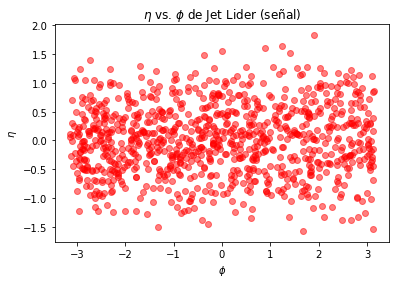

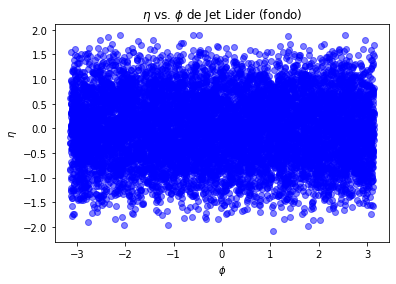

In [46]:
# Relación entre eta y phi

# señal
fig = plt.figure()
plt.scatter(leadphi['senal'], leadeta['senal'], c='r', alpha=0.5)
plt.title(r'$\eta$ vs. $\phi$ de Jet Lider (señal)')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\eta$')

# fondo
fig = plt.figure()
plt.scatter(leadphi['fondo'], leadeta['fondo'], c='b', alpha=0.5)
plt.title(r'$\eta$ vs. $\phi$ de Jet Lider (fondo)')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\eta$')